# **Download Datasets from Kaggle**

In [73]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alfarandy","key":"1a8b59b93c2c36cdc8223d9f8d2be545"}'}

In [74]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [75]:
!rm -rf data

In [76]:
!kaggle datasets download -d sumn2u/garbage-classification-v2

Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT
garbage-classification-v2.zip: Skipping, found more recently modified local copy (use --force to force download)


# **Import Library**

In [77]:
!pip install tensorflow===2.9.0

In [78]:
!pip install augmentor

In [79]:
import tensorflow as tf
print(tf.__version__)

2.9.0


In [80]:
import imghdr
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
from glob import glob
import matplotlib.image as img
import zipfile
import shutil
from PIL import Image
import Augmentor

# **Data Extraction**

In [81]:
local_zip = 'garbage-classification-v2.zip'
target_extraction = '/content/data/dataset/'
file_check = "dataset"

try:
    if os.path.exists(os.path.join(target_extraction, file_check)):
        print("File Already Extracted")
    else:
        zip_ref = zipfile.ZipFile(local_zip, 'r')
        zip_ref.extractall(target_extraction)

except FileNotFoundError:
    print('Zip File Not Found!')

# **Cleaning Dataset**

In [82]:
count=0
image_extensions = [".png", ".jpg"]
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in pathlib.Path('/content/data/dataset/').rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/content/data/dataset/metal/metal_1441.jpg is not an image
/content/data/dataset/metal/metal_1441.jpg is a None, not accepted by TensorFlow
/content/data/dataset/plastic/plastic_2631.jpg is not an image
/content/data/dataset/plastic/plastic_2631.jpg is a None, not accepted by TensorFlow
/content/data/dataset/plastic/plastic_440.jpg is not an image
/content/data/dataset/plastic/plastic_440.jpg is a None, not accepted by TensorFlow
/content/data/dataset/plastic/plastic_2038.jpg is not an image
/content/data/dataset/plastic/plastic_2038.jpg is a None, not accepted by TensorFlow
/content/data/dataset/plastic/plastic_2377.jpg is not an image
/content/data/dataset/plastic/plastic_2377.jpg is a None, not accepted by TensorFlow
/content/data/dataset/plastic/plastic_1394.jpg is not an image
/content/data/dataset/plastic/plastic_1394.jpg is a None, not accepted by TensorFlow
/content/data/dataset/plastic/plastic_222.jpg is not an image
/content/data/dataset/plastic/plastic_222.jpg is a None, not

# **Checking Dataset**

In [83]:
path = '/content/data/dataset/'
counter = 0
dir_names=['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

for file in (dir_names):
    dir = os.listdir(f"{path}/{file}")

    print(f"There are {len(dir)} images of {file}")

There are 945 images of battery
There are 985 images of biological
There are 2331 images of cardboard
There are 5325 images of clothes
There are 4090 images of glass
There are 1868 images of metal
There are 2712 images of paper
There are 2517 images of plastic
There are 1977 images of shoes
There are 834 images of trash


# **Limit Dataset Images 1800 per Class**

In [84]:
dir_names=['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

for dir_names in os.listdir(path):
    count = 0
    delete = 0
    for image in os.listdir(path + '/'  + dir_names):
        count += 1
        while count > 1800:
            random_image = random.choice(os.listdir(path + '/' + dir_names))
            delete_image = path + '/'  + dir_names +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1

    print(f'Deleted {delete} in {dir_names}')

Deleted 68 in metal
Deleted 0 in battery
Deleted 717 in plastic
Deleted 177 in shoes
Deleted 0 in trash
Deleted 2290 in glass
Deleted 912 in paper
Deleted 3525 in clothes
Deleted 0 in biological
Deleted 531 in cardboard


In [85]:
path = '/content/data/dataset/'
counter = 0
dir_names=['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

for file in (dir_names):
    dir = os.listdir(f"{path}/{file}")

    print(f"There are {len(dir)} images of {file}")

There are 945 images of battery
There are 985 images of biological
There are 1800 images of cardboard
There are 1800 images of clothes
There are 1800 images of glass
There are 1800 images of metal
There are 1800 images of paper
There are 1800 images of plastic
There are 1800 images of shoes
There are 834 images of trash


# **Dataset Augmentation**

In [86]:
def convert_images_to_rgb(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            try:
                with Image.open(file_path) as img:
                    if img.mode != 'RGB':
                        rgb_img = img.convert('RGB')
                        rgb_img.save(file_path)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

In [87]:
def copy_images(source_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for filename in os.listdir(source_dir):
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_dir, filename)
        if os.path.isfile(source_path):
            shutil.copy2(source_path, target_path)

In [88]:
def augment_images(input_dir, output_dir, samples_to_generate):
    p = Augmentor.Pipeline(input_dir, output_directory=output_dir)

    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.5)
    p.flip_top_bottom(probability=0.5)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.resize(probability=1.0, width=150, height=150)
    p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
    p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)

    try:
        p.sample(samples_to_generate)
    except Exception as e:
        print(f"Error during augmentation: {e}")

In [89]:
dir_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

for dir_name in dir_names:
    input_dir = f"/content/data/dataset/{dir_name}"
    output_dir = f"/content/data/final_dataset/{dir_name}"

    convert_images_to_rgb(input_dir)

    initial_image_count = len(os.listdir(input_dir))

    if initial_image_count >= 1800:
        copy_images(input_dir, output_dir)
    else:
        samples_to_generate = 1800
        augment_images(input_dir, output_dir, samples_to_generate)

Initialised with 945 image(s) found.
Output directory set to /content/data/final_dataset/battery.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FEFDEEC44F0>: 100%|██████████| 1800/1800 [00:21<00:00, 81.84 Samples/s] 


Initialised with 985 image(s) found.
Output directory set to /content/data/final_dataset/biological.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FEFE02495D0>: 100%|██████████| 1800/1800 [00:16<00:00, 112.01 Samples/s]


Initialised with 834 image(s) found.
Output directory set to /content/data/final_dataset/trash.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7FEFDEEFBBE0>: 100%|██████████| 1800/1800 [00:19<00:00, 90.03 Samples/s] 


# **Dataset after Augmentation**

In [90]:
output_dir = pathlib.Path('/content/data/final_dataset/')
image_count_train = len(list(output_dir.glob('*/*.jpg')))
print(image_count_train)

18000


# **Split Dataset Into Training and Validation**

In [91]:
root_dir = pathlib.Path('/content/data/final_dataset')

In [92]:
batch_size=64
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root_dir,
  shuffle=True,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(150, 150),
  batch_size=batch_size)

Found 18000 files belonging to 10 classes.
Using 14400 files for training.


In [93]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root_dir,
  shuffle=True,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(150,150),
  batch_size=batch_size)

Found 18000 files belonging to 10 classes.
Using 3600 files for validation.


In [94]:
validation_size = int(0.5 * val_ds.cardinality().numpy())
test_ds = val_ds.take(validation_size)
val_ds = val_ds.skip(validation_size)

In [95]:
print("Training Set Size: %d" % train_ds.cardinality().numpy())
print("Validation Set Size: %d" % val_ds.cardinality().numpy())
print("Test Set Size: %d" % test_ds.cardinality().numpy())

Training Set Size: 225
Validation Set Size: 29
Test Set Size: 28


# **Plot Dataset (Each Class)**

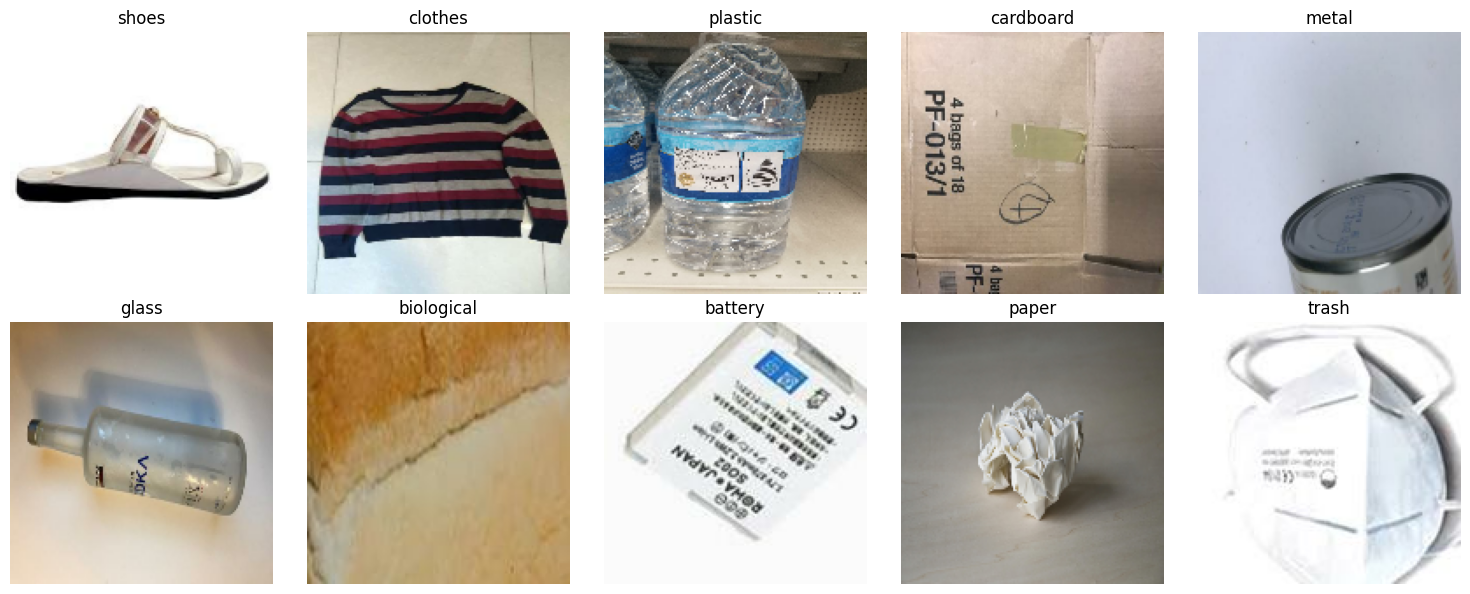

In [96]:
class_names = train_ds.class_names

examples = {}
for images, labels in val_ds:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if class_name not in examples:
            examples[class_name] = image
            break
    if len(examples) == len(class_names):
        break

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, (class_name, image) in enumerate(examples.items()):
    axes[i].imshow(image.numpy().astype("uint8"))
    axes[i].set_title(class_name)
    axes[i].axis('off')

for j in range(len(class_names), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# **Parameter**

In [97]:
IMG_SIZE = (150,150)
IMG_SHAPE = IMG_SIZE + (3,)

# **Architecture using Transfer Learning (ResNet50)**

In [98]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [99]:
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

94765736/94765736 [==============================] - 0s 0us/step


In [100]:
learning_rate = 0.001

model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])

# **Set Callbacks**

In [101]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= 0.96:
                print("\nReached 96% validation accuracy so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

# **Train the Model**

In [102]:
initial_epochs = 10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    validation_steps=int(0.2*len(val_ds)),
                    epochs=initial_epochs,
                    callbacks=[callbacks])

Epoch 1/10
225/225 [==============================] - 957s 4s/step - loss: 0.5575 - accuracy: 0.8219 - val_loss: 0.2782 - val_accuracy: 0.8938
Epoch 2/10
225/225 [==============================] - 1012s 4s/step - loss: 0.2463 - accuracy: 0.9214 - val_loss: 0.2067 - val_accuracy: 0.9375
Epoch 3/10
225/225 [==============================] - 1039s 5s/step - loss: 0.1622 - accuracy: 0.9451 - val_loss: 0.1612 - val_accuracy: 0.9531
Epoch 4/10
225/225 [==============================] - 1038s 5s/step - loss: 0.1163 - accuracy: 0.9616 - val_loss: 0.1247 - val_accuracy: 0.9594
Epoch 5/10
225/225 [==============================] - 1026s 5s/step - loss: 0.0928 - accuracy: 0.9706 - val_loss: 0.1018 - val_accuracy: 0.9594
Epoch 6/10
225/225 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9793
Reached 96% validation accuracy so cancelling training!
225/225 [==============================] - 986s 4s/step - loss: 0.0660 - accuracy: 0.9793 - val_loss: 0.1549 - val_accuracy: 0.97

# **Save Model**

In [103]:
model.save('./model_weights/model.h5')

# **Plot Training and Validation**

Text(0.5, 1.0, 'Training vs Validation Loss')

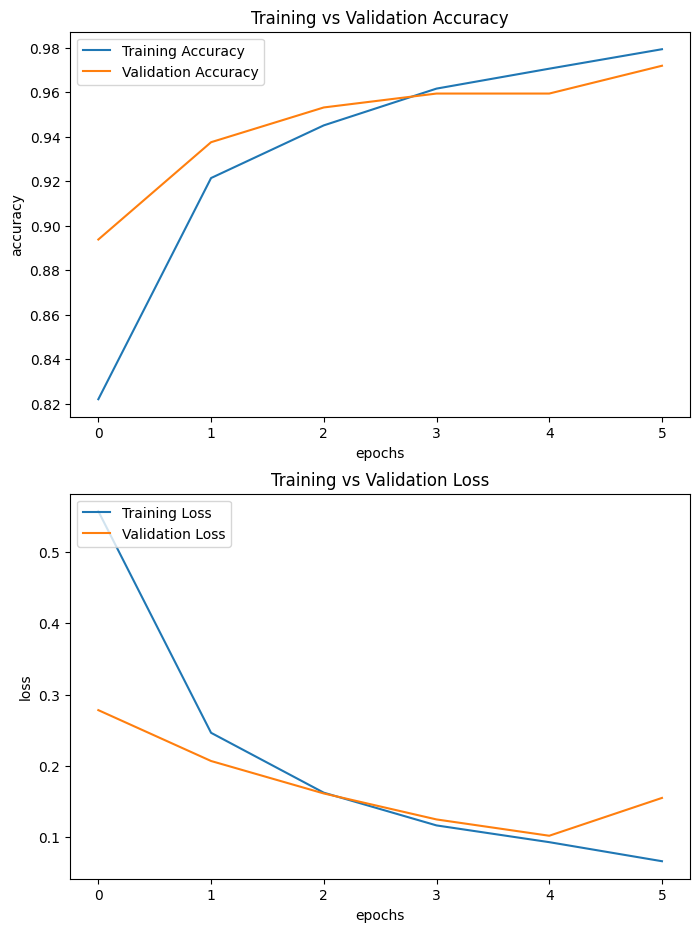

In [104]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 11))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.title('Training vs Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.title('Training vs Validation Loss')

# **Evaluate Model**

In [105]:
model.evaluate(test_ds)

28/28 [==============================] - 113s 4s/step - loss: 0.1845 - accuracy: 0.9520


[0.1844550222158432, 0.9520089030265808]

# **Load and Test Model**

In [106]:
print(train_ds.class_names)
label = train_ds.class_names

['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [107]:
from tensorflow.keras.models import load_model
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

In [108]:
model = load_model('/content/model_weights/model.h5')

In [109]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [110]:
model.evaluate(test_ds)

28/28 [==============================] - 119s 4s/step - loss: 0.1888 - accuracy: 0.9531


[0.18876230716705322, 0.953125]

In [129]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))

  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  result = classes[0]
  for count, x in enumerate(result):
    print(f'{label[count]}: {round(result[count] * 100)}% accuracy')

  predicted_label = np.argmax(result)
  max_label = np.max(result)

  print(f'\nThis is {label[predicted_label]} with {round(result[predicted_label] * 100)}% accuracy')

  name = list(uploaded.keys())
  !rm '{name[0]}'

Saving trash sikat gigi.jpg to trash sikat gigi.jpg
1/1 [==============================] - 0s 90ms/step
battery: 0% accuracy
biological: 0% accuracy
cardboard: 0% accuracy
clothes: 0% accuracy
glass: 0% accuracy
metal: 0% accuracy
paper: 0% accuracy
plastic: 0% accuracy
shoes: 0% accuracy
trash: 100% accuracy

This is trash with 100% accuracy


# **Deploy to TFLite**

In [130]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [131]:
tflite_name = 'model.tflite'

with open(tflite_name, 'wb') as f:
  f.write(tflite_model)

# **Download Model**

In [132]:
from google.colab import files
files.download("model_weights/model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [133]:
from google.colab import files
files.download("model.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>